In [87]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import subprocess as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import pickle

## Config

In [88]:
SEARCH_BS = False
# SEARCH_BS = True
SEARCH_LR = False
# SEARCH_LR = True

In [89]:
# Resize images
resize_img = 1300
resize_img = int(32*int(resize_img/32))

# Batch size
BS_train = 4
if SEARCH_LR:
    BS_train = int(BS_train / 4)
    if BS_train == 0:
        BS_train = 1
BS_val = BS_train * 4

# Train
EPOCHS = 400
# EPOCHS = 3
LR = 1e-2

# Save best model
NOTEBOOK_NAME = '09_Resnet50_smp'

# Dataset split
VALID_SPLIT = 0.2

# Model
number_of_classes = 2 # 2 classes
number_of_channels = 3
encoder_name = 'resnet50'
encoder_weights = 'imagenet'
activation = None

# Learning rate decay
LE_DECAY_FACTOR = 0.1
LE_DECAY_PATIENCE = 10

# Early stopping
EARLY_STOPPING_PATIENCE = 30

# Epochs when model can be saved
MIN_SAVE_EPOCHS = 10

## Dataframe

In [90]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv']

In [91]:
train_images_path = data_path / "train_images"

In [92]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## Dice coefficient loss

In [93]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Dataset and Dataloader

In [94]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [95]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [96]:
train_split, val_split = train_test_split(train_df, test_size=VALID_SPLIT, shuffle=True, random_state=42, stratify=train_df['organ'])
dataset = {
    'train': Dataset(train_split, n_classes=2, dim=resize_img),
    'val': Dataset(val_split, n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 280 imágenes de entrenamiento y 71 imágenes de validación


In [97]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

## Model initialization

In [98]:
def model_init():
    model = smp.Unet(encoder_name, encoder_weights=encoder_weights, in_channels=number_of_channels, classes=number_of_classes, activation=activation)
    return model

## Batch size finder

In [99]:
if SEARCH_BS:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [100]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [101]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [102]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    print(BSs)

In [103]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                if "CUDA out of memory" in str(e):
                    position = str(e).index('CUDA out of memory')
                    print(f"\t{str(e)[position:]}")
                    out_of_memory = True
                    break
                else:
                    out_of_memory = False
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [104]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [105]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [106]:
if SEARCH_LR:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [107]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [108]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    train_loss, train_dice = [], []
    model.train()
    # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
    for imgs, masks in bar:
        # X and y to device
        imgs, masks = imgs.to(device), masks.to(device)
        # Compute prediction and loss
        pred_mask = model(imgs)
        loss = loss_fn(pred_mask, masks)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update train loss and dice
        dice = dice_coeff(pred_mask, masks)
        train_loss.append(loss.item())
        train_dice.append(dice)
        # Update progress bar
        bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    hist['dice'].append(np.mean(train_dice))
    return hist

def valid_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    val_loss, val_dice = [], []
    model.eval()
    with torch.no_grad():
        # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            # Update test loss and dice
            dice = dice_coeff(pred_mask, masks)
            val_loss.append(loss.item())
            val_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tval_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
    hist['val_loss'].append(np.mean(val_loss))
    hist['val_dice'].append(np.mean(val_dice))
    return hist

def fit(model, dataloader, device, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    early_stop_counter = 0
    model_folder = path/'models'
    model_full_name = model_folder/ NOTEBOOK_NAME
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=LE_DECAY_FACTOR, patience=LE_DECAY_PATIENCE, verbose=True)
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': []}
    for epoch in range(epochs):
        # Train
        bar = tqdm(dataloader['train'])
        hist = train_loop(dataloader, model, criterion, optimizer, bar, hist, device)

        # Validation
        bar = tqdm(dataloader['val'])
        hist = valid_loop(dataloader, model, criterion, optimizer, bar, hist, device)
        
        # Print epoch results
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")

        # Save model if best dice
        if hist['val_dice'][-1] > best_dice and epoch >= MIN_SAVE_EPOCHS:
            best_dice = hist['val_dice'][-1]
            model_full_path = model_full_name.with_suffix('.pth')
            torch.save(model, model_full_path)
            print(f"New best dice: {best_dice:.5f}, model saved to {model_full_path}")
        
        # Update scheduler
        schedulerOnPlateau.step(hist['val_loss'][-1])

        # Early stopping
        if hist['val_dice'][-1] < best_dice:
            early_stop_counter += 1
            if early_stop_counter > EARLY_STOPPING_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
        else:
            early_stop_counter = 0
        
    # Save final model
    final_model_full_path = str(model_full_name) + '_final.pth'
    torch.save(model, final_model_full_path)
    
    return hist

In [109]:
if not SEARCH_BS and not SEARCH_LR:
    model = model_init()
    hist = fit(model, dataloader, device, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		val_loss 0.30747 val_dice -130.17094: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 001/400 loss 0.29409 dice 6.70242 val_loss 0.30747 val_dice -130.17094


		val_loss 0.35329 val_dice 5.13630: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 002/400 loss 0.25718 dice 8.49527 val_loss 0.35329 val_dice 5.13630


		val_loss 0.60784 val_dice 9.19759: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Epoch 003/400 loss 0.25015 dice 8.97325 val_loss 0.60784 val_dice 9.19759


		val_loss 0.27965 val_dice 6.14693: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 004/400 loss 0.25071 dice 8.62089 val_loss 0.27965 val_dice 6.14693


		val_loss 0.56520 val_dice 0.61250: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 005/400 loss 0.24190 dice 8.61303 val_loss 0.56520 val_dice 0.61250


		val_loss 0.27818 val_dice 5.83210: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 006/400 loss 0.24632 dice 8.84149 val_loss 0.27818 val_dice 5.83210


		val_loss 0.31362 val_dice 8.36476: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 007/400 loss 0.24321 dice 8.91451 val_loss 0.31362 val_dice 8.36476


		val_loss 0.49863 val_dice 1.52887: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 008/400 loss 0.22734 dice 9.60179 val_loss 0.49863 val_dice 1.52887


		val_loss 0.39851 val_dice 2.28908: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 009/400 loss 0.22531 dice 8.83014 val_loss 0.39851 val_dice 2.28908


		val_loss 0.26629 val_dice 8.88897: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 010/400 loss 0.22361 dice 9.28267 val_loss 0.26629 val_dice 8.88897


		val_loss 0.26369 val_dice 6.39440: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 011/400 loss 0.21907 dice 9.32724 val_loss 0.26369 val_dice 6.39440
New best dice: 6.39440, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.51414 val_dice 1.76473: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 012/400 loss 0.22048 dice 9.41924 val_loss 0.51414 val_dice 1.76473


		val_loss 0.53700 val_dice 1.31142: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 013/400 loss 0.22080 dice 9.44618 val_loss 0.53700 val_dice 1.31142


		val_loss 0.27128 val_dice 6.24500: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 014/400 loss 0.21587 dice 9.24854 val_loss 0.27128 val_dice 6.24500
Epoch 00014: reducing learning rate of group 0 to 1.0000e-03.


		val_loss 0.23592 val_dice 9.46911: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Epoch 015/400 loss 0.20201 dice 10.57171 val_loss 0.23592 val_dice 9.46911
New best dice: 9.46911, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.35912 val_dice 4.03971: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 016/400 loss 0.20284 dice 10.49682 val_loss 0.35912 val_dice 4.03971


		val_loss 0.23025 val_dice 9.92701: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 017/400 loss 0.19473 dice 10.58213 val_loss 0.23025 val_dice 9.92701
New best dice: 9.92701, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.22875 val_dice 10.13921: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 018/400 loss 0.19878 dice 10.64947 val_loss 0.22875 val_dice 10.13921
New best dice: 10.13921, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.22994 val_dice 9.83001: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 019/400 loss 0.19771 dice 10.66550 val_loss 0.22994 val_dice 9.83001


		val_loss 0.23214 val_dice 10.40337: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 020/400 loss 0.19716 dice 10.80587 val_loss 0.23214 val_dice 10.40337
New best dice: 10.40337, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.48325 val_dice 2.34711: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 021/400 loss 0.19227 dice 10.90567 val_loss 0.48325 val_dice 2.34711


		val_loss 0.22945 val_dice 9.85805: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 022/400 loss 0.19038 dice 11.04365 val_loss 0.22945 val_dice 9.85805


		val_loss 0.22389 val_dice 11.20479: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 023/400 loss 0.19007 dice 11.07464 val_loss 0.22389 val_dice 11.20479
New best dice: 11.20479, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.23024 val_dice 9.20816: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 024/400 loss 0.19233 dice 11.14459 val_loss 0.23024 val_dice 9.20816


		val_loss 0.34063 val_dice 11.29574: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 025/400 loss 0.18807 dice 11.31359 val_loss 0.34063 val_dice 11.29574
New best dice: 11.29574, model saved to ../models/09_Resnet50_smp.pth
Epoch 00025: reducing learning rate of group 0 to 1.0000e-04.


		val_loss 0.22432 val_dice 10.23801: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 026/400 loss 0.18538 dice 11.33981 val_loss 0.22432 val_dice 10.23801


		val_loss 0.22307 val_dice 9.84781: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 027/400 loss 0.18513 dice 11.36557 val_loss 0.22307 val_dice 9.84781


		val_loss 0.22391 val_dice 10.04152: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 028/400 loss 0.18147 dice 11.40324 val_loss 0.22391 val_dice 10.04152


		val_loss 0.22689 val_dice 9.90827: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 029/400 loss 0.18175 dice 11.35733 val_loss 0.22689 val_dice 9.90827


		val_loss 0.22798 val_dice 10.22602: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 030/400 loss 0.18196 dice 11.45651 val_loss 0.22798 val_dice 10.22602


		val_loss 0.22060 val_dice 10.96380: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 031/400 loss 0.18141 dice 11.43783 val_loss 0.22060 val_dice 10.96380


		val_loss 0.22235 val_dice 11.48768: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 032/400 loss 0.18043 dice 11.52845 val_loss 0.22235 val_dice 11.48768
New best dice: 11.48768, model saved to ../models/09_Resnet50_smp.pth


		val_loss 0.21969 val_dice 11.13754: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 033/400 loss 0.18500 dice 11.39904 val_loss 0.21969 val_dice 11.13754


		val_loss 0.22037 val_dice 10.63214: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 034/400 loss 0.18110 dice 11.51448 val_loss 0.22037 val_dice 10.63214


		val_loss 0.21808 val_dice 10.12833: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 035/400 loss 0.17805 dice 11.46537 val_loss 0.21808 val_dice 10.12833


		val_loss 0.21859 val_dice 10.60568: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 036/400 loss 0.18028 dice 11.66720 val_loss 0.21859 val_dice 10.60568
Epoch 00036: reducing learning rate of group 0 to 1.0000e-05.


		val_loss 0.22143 val_dice 10.22654: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 037/400 loss 0.17869 dice 11.74011 val_loss 0.22143 val_dice 10.22654


		val_loss 0.22771 val_dice 10.55209: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 038/400 loss 0.17858 dice 11.89523 val_loss 0.22771 val_dice 10.55209


		val_loss 0.21820 val_dice 10.91861: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 039/400 loss 0.17902 dice 11.72703 val_loss 0.21820 val_dice 10.91861


		val_loss 0.22256 val_dice 10.50203: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 040/400 loss 0.17794 dice 11.74763 val_loss 0.22256 val_dice 10.50203


		val_loss 0.22369 val_dice 10.42827: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 041/400 loss 0.18003 dice 11.78030 val_loss 0.22369 val_dice 10.42827


		val_loss 0.21941 val_dice 10.92321: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 042/400 loss 0.18025 dice 11.85359 val_loss 0.21941 val_dice 10.92321


		val_loss 0.21713 val_dice 10.96474: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 043/400 loss 0.17855 dice 11.74729 val_loss 0.21713 val_dice 10.96474


		val_loss 0.22484 val_dice 11.14582: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 044/400 loss 0.17864 dice 11.74967 val_loss 0.22484 val_dice 11.14582


		val_loss 0.22025 val_dice 10.49174: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 045/400 loss 0.17600 dice 11.73406 val_loss 0.22025 val_dice 10.49174


		val_loss 0.21877 val_dice 10.84518: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 046/400 loss 0.17775 dice 11.85992 val_loss 0.21877 val_dice 10.84518


		val_loss 0.22186 val_dice 10.76764: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 047/400 loss 0.17859 dice 11.79965 val_loss 0.22186 val_dice 10.76764
Epoch 00047: reducing learning rate of group 0 to 1.0000e-06.


		val_loss 0.22158 val_dice 10.42837: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 048/400 loss 0.18112 dice 11.82417 val_loss 0.22158 val_dice 10.42837


		val_loss 0.21886 val_dice 10.29419: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 049/400 loss 0.17390 dice 11.76386 val_loss 0.21886 val_dice 10.29419


		val_loss 0.21885 val_dice 10.12822: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 050/400 loss 0.17966 dice 11.88461 val_loss 0.21885 val_dice 10.12822


		val_loss 0.22454 val_dice 10.36276: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Epoch 051/400 loss 0.17525 dice 11.89639 val_loss 0.22454 val_dice 10.36276


		val_loss 0.22031 val_dice 10.94942: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 052/400 loss 0.17799 dice 11.81913 val_loss 0.22031 val_dice 10.94942


		val_loss 0.22637 val_dice 10.19172: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 053/400 loss 0.18247 dice 11.85870 val_loss 0.22637 val_dice 10.19172


		val_loss 0.22074 val_dice 10.61655: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 054/400 loss 0.17642 dice 11.80898 val_loss 0.22074 val_dice 10.61655


		val_loss 0.22335 val_dice 10.05243: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 055/400 loss 0.17675 dice 11.87785 val_loss 0.22335 val_dice 10.05243


		val_loss 0.22193 val_dice 10.62577: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 056/400 loss 0.17938 dice 11.90625 val_loss 0.22193 val_dice 10.62577


		val_loss 0.22265 val_dice 10.56391: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Epoch 057/400 loss 0.17810 dice 11.83593 val_loss 0.22265 val_dice 10.56391


		val_loss 0.22668 val_dice 9.87595: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 058/400 loss 0.17751 dice 11.88007 val_loss 0.22668 val_dice 9.87595
Epoch 00058: reducing learning rate of group 0 to 1.0000e-07.


		val_loss 0.22615 val_dice 10.71699: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 059/400 loss 0.17619 dice 11.85514 val_loss 0.22615 val_dice 10.71699


		val_loss 0.22552 val_dice 10.14318: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Epoch 060/400 loss 0.17971 dice 11.87605 val_loss 0.22552 val_dice 10.14318


		val_loss 0.21902 val_dice 10.94422: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 061/400 loss 0.17814 dice 11.89845 val_loss 0.21902 val_dice 10.94422


		val_loss 0.22208 val_dice 10.59164: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Epoch 062/400 loss 0.17809 dice 11.84732 val_loss 0.22208 val_dice 10.59164


		val_loss 0.22210 val_dice 10.97453: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 063/400 loss 0.17698 dice 11.80927 val_loss 0.22210 val_dice 10.97453
Early stopping at epoch 63


In [110]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
else:
    # Empty dataframe
    hist_df = pd.DataFrame()
hist_df.head()

63


,loss,dice,val_loss,val_dice
0,0.294090,6.702417,0.307469,-130.170935
1,0.257182,8.495274,0.353294,5.136300
2,0.250154,8.973254,0.607837,9.197587
3,0.250710,8.620886,0.279649,6.146934
4,0.241901,8.613031,0.565198,0.612498


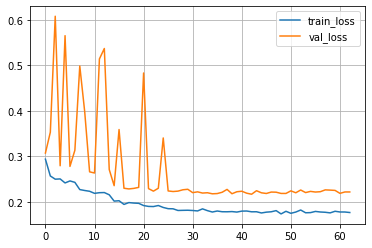

In [111]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

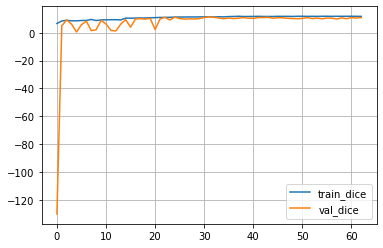

In [112]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.grid()
    plt.show()

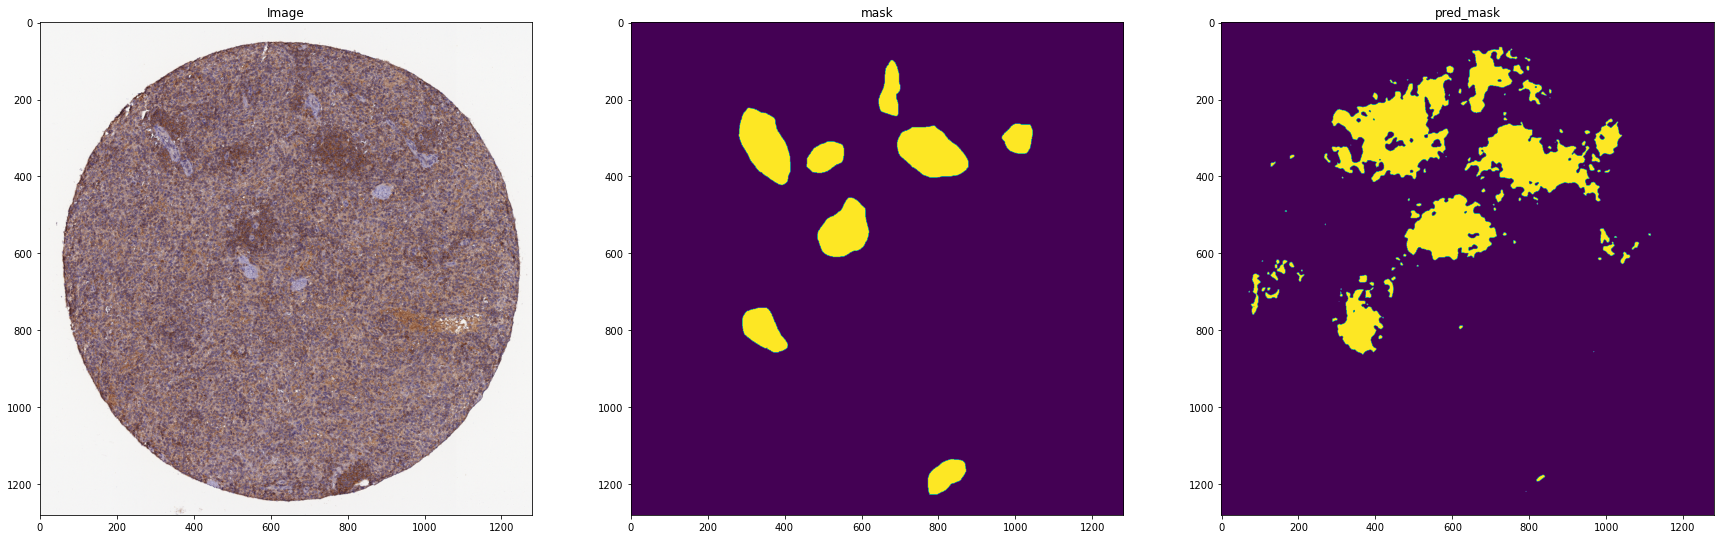

output.shape = torch.Size([2, 1280, 1280]), pred_mask.shape = (1280, 1280)


In [113]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]
    model.cpu()
    model.eval()
    with torch.no_grad():
        output = model(sample_val_img)[0]
        pred_mask = torch.argmax(output, axis=0)
        pred_mask = pred_mask.type(torch.float32)
        pred_mask = pred_mask.detach().cpu().numpy()
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
    ax1.set_title('Image')
    ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
    ax2.set_title('mask')
    ax3.imshow(pred_mask)
    ax3.set_title('pred_mask')
    plt.show()
    print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

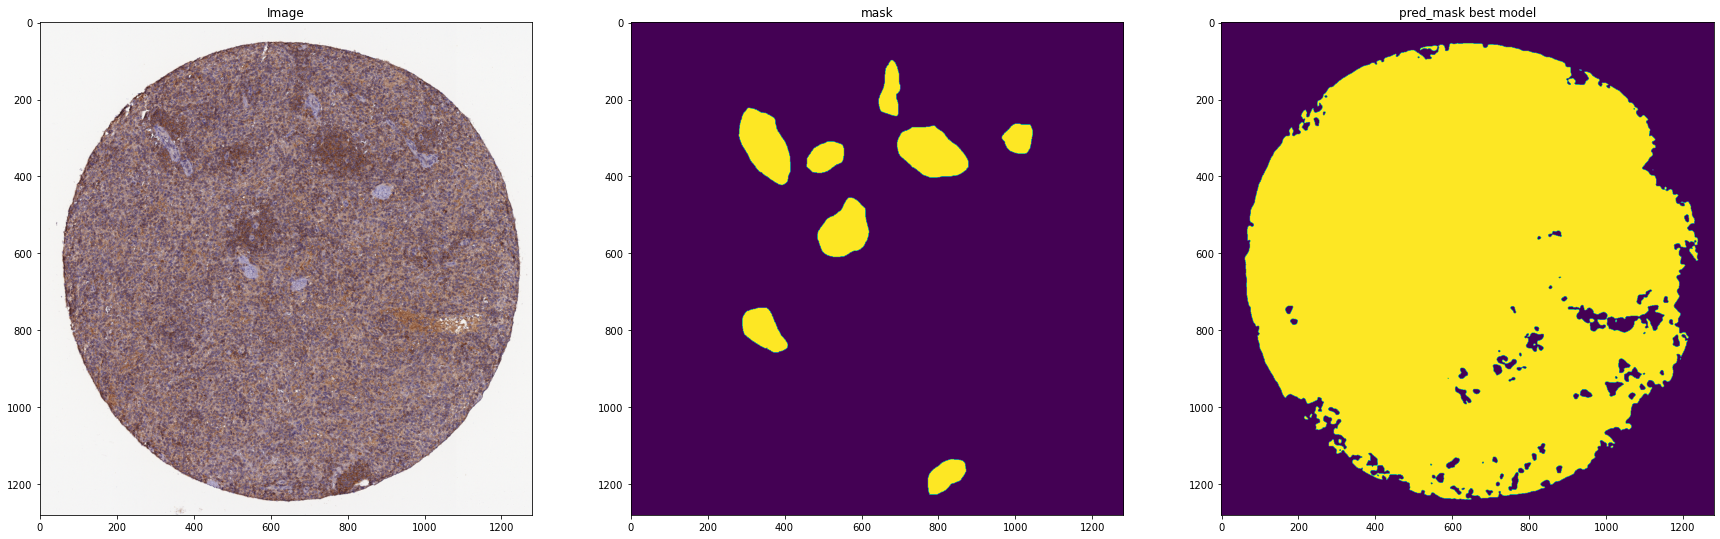

output.shape = torch.Size([2, 1280, 1280]), pred_mask.shape = (1280, 1280)


In [114]:
if not SEARCH_BS and not SEARCH_LR:
    model_folder = path/'models'
    model_full_name = model_folder/ NOTEBOOK_NAME
    best_model_full_path = str(model_full_name) + '.pth'
    model = torch.load(best_model_full_path)
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]
    # model.cpu()
    model.eval()
    with torch.no_grad():
        sample_val_img = sample_val_img.to(device)
        output = model(sample_val_img)[0]
        pred_mask = torch.argmax(output, axis=0)
        pred_mask = pred_mask.type(torch.float32)
        pred_mask = pred_mask.detach().cpu().numpy()
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
    ax1.set_title('Image')
    ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
    ax2.set_title('mask')
    ax3.imshow(pred_mask)
    ax3.set_title('pred_mask best model')
    plt.show()
    print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

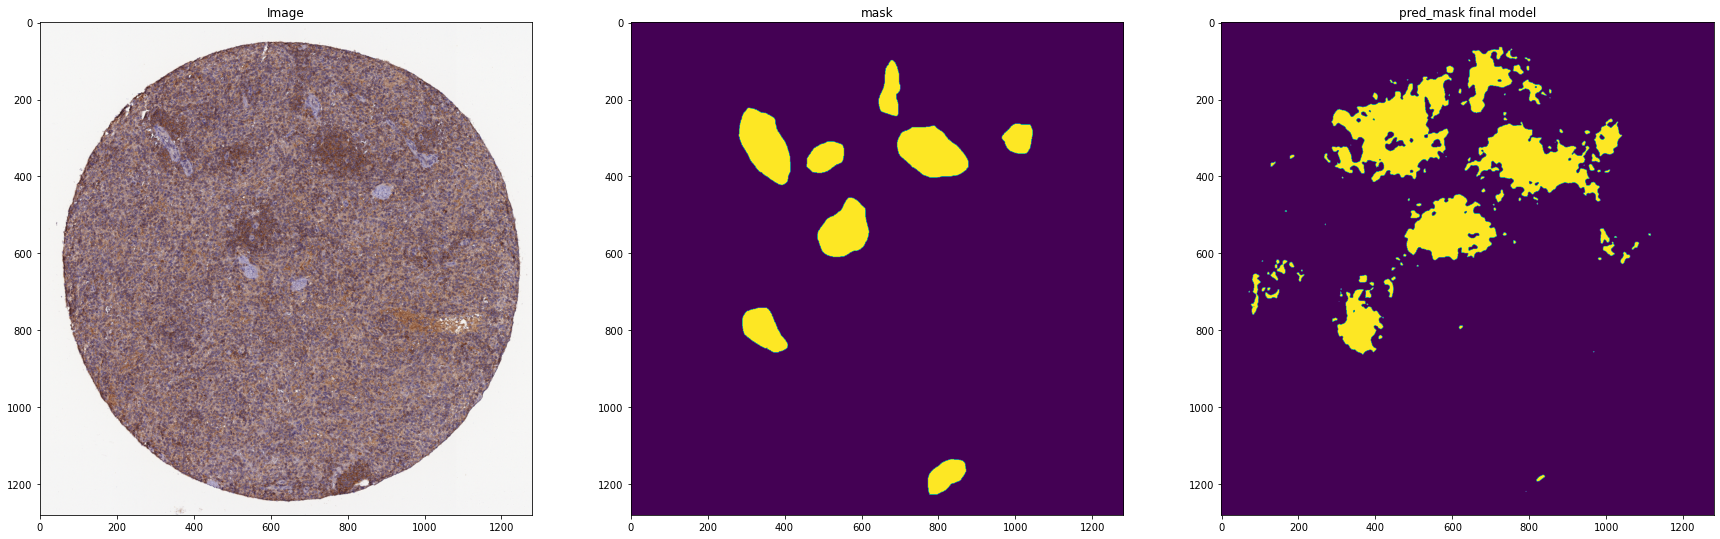

output.shape = torch.Size([2, 1280, 1280]), pred_mask.shape = (1280, 1280)


In [115]:
if not SEARCH_BS and not SEARCH_LR:
    model_folder = path/'models'
    model_full_name = model_folder/ NOTEBOOK_NAME
    final_model_full_path = str(model_full_name) + '_final.pth'
    model = torch.load(final_model_full_path)
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]
    # model.cpu()
    model.eval()
    with torch.no_grad():
        sample_val_img = sample_val_img.to(device)
        output = model(sample_val_img)[0]
        pred_mask = torch.argmax(output, axis=0)
        pred_mask = pred_mask.type(torch.float32)
        pred_mask = pred_mask.detach().cpu().numpy()
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
    ax1.set_title('Image')
    ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
    ax2.set_title('mask')
    ax3.imshow(pred_mask)
    ax3.set_title('pred_mask final model')
    plt.show()
    print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")